# PyTorch Recurrent Neural Network
Based off this PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

In [2]:
def findFiles(path): return glob.glob(path)


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


In [3]:
category_lines = {}
all_categories = []

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Create the Network
Using PyTorch the 'recurrent' part can be entirely handled by the graph itself. Meaning we can implement a RNN as a regular feed-forward layers.

![](https://i.imgur.com/Z2xbySO.png)

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    
        

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
my_input = letterToTensor('A')
hidden = rnn.initHidden()

output, next_hidden = rnn(my_input, hidden)

In [10]:
output

tensor([[-2.8583, -2.8685, -2.9257, -2.8926, -2.8447, -2.8479, -2.8877, -3.0408,
         -2.9576, -2.8477, -2.8860, -2.9126, -2.8452, -2.9219, -2.8262, -2.9954,
         -2.8924, -2.8058]], grad_fn=<LogSoftmaxBackward0>)

##  Helpers

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [12]:
print(categoryFromOutput(output))

('Spanish', 17)


In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Gouveia
category = Polish / line = Rutkowski
category = Vietnamese / line = Than
category = Irish / line = Keefe
category = Greek / line = Papadopulos
category = Chinese / line = Yin
category = Japanese / line = Ninomiya
category = Korean / line = Ryom
category = Portuguese / line = De santigo
category = Japanese / line = Suzuki


In [14]:
criterion = nn.NLLLoss()

In [15]:
learning_rate = 0.005

In [16]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add params' gradients to their values, multiplied by lr
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [17]:
import time
import math

n_iters = 100_000
print_every = 5_000
plot_every = 1_000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.6046 Dao / Portuguese ✗ (Vietnamese)
10000 10% (0m 19s) 2.2294 Forstner / Dutch ✗ (German)
15000 15% (0m 25s) 2.6533 Grant / Vietnamese ✗ (Scottish)
20000 20% (0m 30s) 1.7508 Mathghamhain / Russian ✗ (Irish)
25000 25% (0m 36s) 3.4214 Mata / Japanese ✗ (Portuguese)
30000 30% (0m 41s) 0.1147 Hatakeyama / Japanese ✓
35000 35% (0m 47s) 1.6252 Herrero / Spanish ✓
40000 40% (0m 52s) 1.0544 Zhao / Chinese ✓
45000 45% (0m 58s) 0.7846 Breiner / German ✓
50000 50% (1m 3s) 2.1417 Millett / Dutch ✗ (English)
55000 55% (1m 9s) 1.4468 Jedynak / Czech ✗ (Polish)
60000 60% (1m 14s) 2.2841 Denend / German ✗ (Dutch)
65000 65% (1m 20s) 1.0349 Krhovsky / Russian ✗ (Czech)
70000 70% (1m 25s) 2.7987 Salomon / English ✗ (French)
75000 75% (1m 31s) 0.3894 Kowalczyk / Polish ✓
80000 80% (1m 37s) 1.7238 Krebs / Arabic ✗ (German)
85000 85% (1m 42s) 1.0018 Bolcar / Czech ✓
90000 90% (1m 48s) 0.8500 Gu / Korean ✓
95000 95% (1m 53s) 0.6906 Cucinotta / Italian ✓
100000 100% (2m 0s) 1.4135 Devin / 

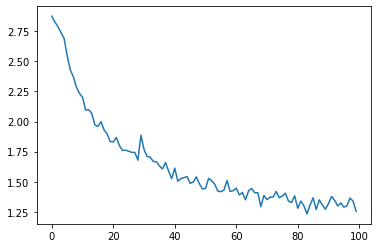

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [19]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10_000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


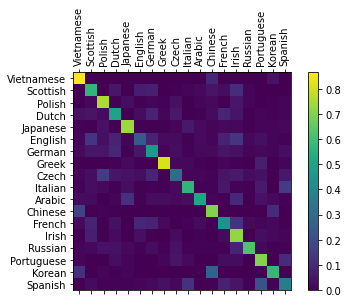

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [21]:
def predict(input_line, n_predictions=3):
    print(f"\n> {input_line}")
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [22]:
predict('Dovesky')


> Dovesky
(-0.70) Russian
(-1.18) Czech
(-2.36) Irish


In [23]:
predict('Habu')


> Habu
(-0.98) Japanese
(-1.62) Arabic
(-2.36) German


In [36]:
predict("Muhammad")


> Muhammad
(-0.38) Arabic
(-2.61) Japanese
(-2.62) French
